# WDNN - Hyperparameter Tuning

# Imports

In [1]:
# Standard imports
import numpy as np 
import pandas as pd 
import os 

# For loading data from Drive
from google.colab import drive

# Plotting 
import matplotlib.pyplot as plt 
from matplotlib import style
style.use('ggplot')
%matplotlib inline 
from seaborn import distplot, heatmap

# Scikit-Learn imports
from sklearn.model_selection import RandomizedSearchCV, train_test_split 
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

# Tensorflow and Keras
from tensorflow import keras

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Loading Data

In [2]:
# Mount Google Drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
# Defining filepaths
ROOT_DIR = "/content/drive/My Drive"
FYP_DIR = "EE 16-17 FYP DL Energy Theft Detection"
DATA_DIR = "Data/full-processing-data"
FILE_NAME = "outliersRemoved.csv"

# Create filepath
FILE_PATH = os.path.join(ROOT_DIR, FYP_DIR, DATA_DIR, FILE_NAME)

In [4]:
# Print the filepath for checking
print(FILE_PATH)

/content/drive/My Drive/EE 16-17 FYP DL Energy Theft Detection/Data/full-processing-data/outliersRemoved.csv


In [0]:
df = pd.read_csv(FILE_PATH)

In [6]:
# Did it work?
df.head()

,CONS_NO,FLAG,2014-01-01,2014-01-02,2014-01-03,2014-01-04,2014-01-05,2014-01-06,2014-01-07,2014-01-08,2014-01-09,2014-01-10,2014-01-11,2014-01-12,2014-01-13,2014-01-14,2014-01-15,2014-01-16,2014-01-17,2014-01-18,2014-01-19,2014-01-20,2014-01-21,2014-01-22,2014-01-23,2014-01-24,2014-01-25,2014-01-26,2014-01-27,2014-01-28,2014-01-29,2014-01-30,2014-01-31,2014-02-01,2014-02-02,2014-02-03,2014-02-04,2014-02-05,2014-02-06,2014-02-07,...,2016-09-22,2016-09-23,2016-09-24,2016-09-25,2016-09-26,2016-09-27,2016-09-28,2016-09-29,2016-09-30,2016-10-01,2016-10-02,2016-10-03,2016-10-04,2016-10-05,2016-10-06,2016-10-07,2016-10-08,2016-10-09,2016-10-10,2016-10-11,2016-10-12,2016-10-13,2016-10-14,2016-10-15,2016-10-16,2016-10-17,2016-10-18,2016-10-19,2016-10-20,2016-10-21,2016-10-22,2016-10-23,2016-10-24,2016-10-25,2016-10-26,2016-10-27,2016-10-28,2016-10-29,2016-10-30,2016-10-31
0,0387DD8A07E07FDA6271170F86AD9151,1,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,...,8.56,10.48,8.20,12.53,7.90,8.58,10.12,9.96,7.60,18.19,10.93,11.41,19.92,10.70,9.20,6.77,6.760000,6.150000,6.500000,8.080000,7.97,8.810000,7.370000,11.720000,11.020000,8.180000,7.330000,6.710000,8.520000,6.310000,7.18,8.070000,8.090000,9.530000,5.480000,8.750000,9.300000,7.540000,9.160000,6.740000
1,01D6177B5D4FFE0CABA9EF17DAFC2B84,1,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,4B75AC4F2D8434CFF62DB64D0BB43103,1,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,8.34,13.483126,13.483126,13.483126,13.483126,12.73,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126,10.95,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126
3,B32AC8CC6D5D805AC053557AB05F5343,1,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,...,17.30,16.95,8.25,22.76,14.07,20.70,6.50,9.99,18.59,16.79,26.82,14.70,16.05,24.10,12.64,10.85,11.770000,13.030000,12.260000,15.660000,13.43,15.030000,14.610000,13.970000,15.070000,14.110000,14.770000,11.720000,11.730000,11.980000,12.81,15.120000,17.260000,14.910000,19.590000,20.790000,17.950000,19.260000,14.460000,11.720000
4,EDFC78B07BA2908B3395C4EB2304665E,1,2.9,5.64,6.99,3.32,3.61,5.35,4.73,3.68,3.53,3.42,3.81,4.58,3.56,4.25,3.86,3.53,3.41,0.85,0.88,3.81,6.51,9.19,7.79,7.02,7.25,6.37,6.43,7.89,7.46,7.95,7.59,4.84,6.06,5.6,6.72,7.29,5.6,6.28,...,9.56,9.48,10.60,10.06,10.79,10.91,17.77,10.37,13.51,14.13,17.44,15.96,12.18,18.54,13.44,11.68,9.150000,9.160000,10.190000,10.310000,8.03,10.080000,10.340000,11.240000,15.140000,14.360000,12.390000,10.360000,9.290000,7.910000,14.21,10.220000,8.470000,6.110000,6.100000,6.730000,7.520000,10.890000,9.860000,8.720000


# Custom Transformers

## `ZeroPadder` Transformer 
- A custom transformer that I've written to pad feature 2D matrices (`X_train, X_test, X_val`) with the right number of zeroes to make the daily kWh data capable of being transformed to weekly kWh data. 
- I wanted to use `numpy` operations as much as possible because `pandas` operations tend to be slower. 
- I think the `transform` method can be simplified with `np.append`. 

In [0]:
class ZeroPadder(BaseEstimator, TransformerMixin):
  """Custom transformer class for padding 1D numpy array of daily kWh values so
  that the total number of days is evenly divisible into a whole number of weeks.
  
    ATTRIBUTES
    - `days_per_consumer` is the number of kWh entries in 1D array of a single consumer
    - `days_per_week` is the number of days in a week 
    - `weeks_per_consumer` is the minimum number of whole weeks which cover `days_per_consumer`
    - `padding` is the number of `pad_value`s to add to each 1D array.
    - `pad_value` is the value with which the each 1D array in `X` will be padded

    METHODS
    - `pad_zeroes(self, row)`
      Helper function to pad the right number of zeroes to a 1D numpy array `row`. 
      `row` is a single row of the 2D numpy array `X`.

    - `fit(self, X, y=None)` 
      - initializes the attributes with the correct values according to
      the input matrix `X`.
      - returns an instance of the transformer class with the attributes initialised.

    - `transform(self, X, y=None)
      - uses numpy's apply_along_axis function to apply `pad_zeroes` to each row
      of `X`. 
      - Returns 0 padded numpy matrix of dimension (m, n + padding)`
    """  
  def __init__(self):
    """Initialise attributes with dummy values so that they can be reinitialized
    when fit to the array `X`."""
    self.days_per_consumer = 0
    self.days_per_week = 7
    self.weeks_per_consumer = 0
    self.padding = 0
    self.pad_value = 0.0

  def pad_zeroes(self, row):
    """Appends zeroes to end of each 1D numpy array of kWh values"""
    return np.pad(row, pad_width=(0, self.padding), mode='constant', constant_values=self.pad_value)

  def fit(self, X, y=None):
    """Update the attributes based on X""" 
    # Find the number of days of kWh entries for each consumer
    self.days_per_consumer = X.shape[-1]

    # Find the number of weeks in these days rounded to the nearest whole number 
    self.weeks_per_consumer = np.ceil(self.days_per_consumer / self.days_per_week).astype('uint8')

    # Number of zeros for padding = number of extra days required to turn days_per_consumer
    # into a number that is equivalent to a whole number of weeks
    self.padding = self.weeks_per_consumer * self.days_per_week - self.days_per_consumer

    # Once parameters have been fit, just return the updated instance of the transformer
    return self

  def transform(self, X, y=None):
    """Transform the data according to the specified attributes"""

    # TODO: A simpler way to do this would be to use np.append(X, np.zeros((len(X), self.padding)), axis=1)
    # This will eliminate the apply_along_axis call and nested calls to pad_zeroes
    # Pad zeroes is more complicated than required for this application
    return np.apply_along_axis(self.pad_zeroes, axis=1, arr=X)

## `DailyToWeekly` Transformer 
- A simple transformer that reshapes the daily kWh data to weekly kWh data. 
- For use with a 2D CNN, must also specify a channels dimension: in this case, channel is 1 (we don't have multiple streams of information for each consumer). 

In [0]:
class DailyToWeekly(BaseEstimator, TransformerMixin):
  """Custom transformer class that reshapes a 1D daily kWh data to 2D weekly data.
  For compatibility with 2D CNN layers, adding a vestigial channels axis with 
  dimensionality of 1"""

  def __init__(self):
    """Initialise a DailyToWeekly transformer with attributes for channel and 
    days per week that can be used in reshaping."""
    self.days = 0
    self.weeks = 0
    self.channels = 1 
    self.days_per_week = 7

  def daily_to_weekly(self, row):
    """Helper function to reshape (n, ) into (number_of_weeks, number_of_days_per_day, 1)
    `row` is a single consumer's vector of kWh data."""
    return row.reshape((self.weeks, self.days_per_week, self.channels))

  def fit(self, X, y=None):
    """Initialise `days` and `weeks` attributes with the right values based on `X`."""
    self.days = X.shape[-1]
    self.weeks = self.days // self.days_per_week

    # Must return instance with attributes initialised
    return self

  def transform(self, X, y=None):
    """Applies the `daily_to_weekly` transformation to each row in `X`"""
    return np.apply_along_axis(self.daily_to_weekly, axis=1, arr=X)

# Pipelines 

## `pipeline_1D` - WNN

This pipeline prepares our data for the WNN component. It consists of the following individual transformations. 
1. `to_numpy`: Convert any `DataFrames` to `numpy` `ndarray`s for faster processing.
2. `row_to_col`: Transpose all features arrays so that rows (consumers) become columns.
3. `scaler`: Apply a user-specified scaling strategy to the transposed data on a column-wise (consumer-wise) basis.
4. `col_to_row`: Retranspose the scaled data so that consumers are once again along the rows axis.

In [0]:
pipeline_1D = Pipeline([
            # Convert all matrices to numpy array for faster processing
            ('to_numpy', FunctionTransformer(pd.DataFrame.to_numpy)),

            # Transpose once so that consumers are now along column axis
            ('row_to_col', FunctionTransformer(np.transpose)), 

            # Use scikit-learn scaler of your choice to scale kWhs on a consumer basis
            ('scaler', StandardScaler()),

            # Retranspose so that consumers are once again along the rows axis
            ('col_to_row', FunctionTransformer(np.transpose)),
])

## `pipeline_2D` - CNN

This pipeline prepares features for the CNN component of our WDNN through the following custom transformers

1. `ZeroPadder`: a transformer that appends to each consumer's kWh array the minimum number of zeroes required for the daily kWh data to be transformable to weekly data.
2. `DailyToWeekly`: a second transformer that reshapes each consumer's kWh data into weekly data with is compatible for the convolutional component of the model

In [0]:
pipeline_2D = Pipeline([
      # Pad each row with zeroes for reshaping 
      ('ZeroPadder', ZeroPadder()),

      # Reshape to a weekly data that can be fed to a CNN
      ('Reshaper_2D', DailyToWeekly())
])

# Extracting features and labels

- `features`: all kWh data (columns at index `2` and onwards)
- `targets`: `FLAG` column in the original dataset. 

In [0]:
features, labels = df.iloc[:, 2:], df.iloc[:, 1]

# Train-Test-Val Split

## Split 1: Train/Test

In [0]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, 
                                                    test_size=0.2, 
                                                    random_state=0, 
                                                    stratify=labels.values)

### Check Shapes

In [0]:
NUM_CONSUMERS, NUM_DAYS = features.shape

In [0]:
# First, confirm one label per example in training and test data
assert len(X_train) == len(y_train)
assert len(X_test) == len(y_test)

# Then, confirm that the training and test features have the right dimensions
assert X_train.ndim == 2
assert X_test.ndim == 2

# Next, confirm that the training and test set have exactly the right number of features
assert X_train.shape[-1] == NUM_DAYS
assert X_test.shape[-1] == NUM_DAYS

# Are all consumers accounted for?
assert len(X_train) + len(X_test) == NUM_CONSUMERS
assert len(y_train) + len(y_test) == NUM_CONSUMERS

# If all shapes are correct, remember them for later
NUM_TRAIN, NUM_TEST = len(X_train), len(X_test)

## Split 2: Train/Val

In [0]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                  random_state=0, 
                                                  test_size=0.2, 
                                                  stratify=y_train.values)

### Check Shapes

In [0]:
# One label per training example in validation set
assert len(X_val) == len(y_val)

# Confirm the validation features have the right dimensions
assert X_val.ndim == 2
assert y_val.ndim == 1

# Confirm that validation set has the right number of features
assert X_val.shape[-1] == NUM_DAYS

# Testing Pipelines

Before I begin hyperparameter tuning, I want to confirm that the `pipeline` approach hasn't introduced errors in my data.

The flow of data is 
1. Load from data source.
2. Stratified train test split
3. Preprocess 1D data to get `X_1D`
    - Convert to `numpy` array.
    - Scale using chosen strategy.
4. Preprocess `X_1D` to get `X_2D`




In [0]:
# First, process the original data to get processed 1D data
X_train_1D, y_train_1D = pipeline_1D.fit_transform(X_train), y_train.copy()

In [0]:
# Then use processed 1D data to get 2D data
X_train_2D, y_train_2D = pipeline_2D.fit_transform(X_train_1D), y_train.copy()

## Test 1 - Distribution of Values

Both the 1D and 2D data should have the normal distribution that we have come to expect from `StandardScaler` features.

In [0]:
def plot_feature_distribution(X, kde=False, arr_name=None):
  plt.figure(figsize=(12, 6))
  distplot(X.ravel(), kde=kde, hist_kws=dict(edgecolor='k', linewidth=2))
  plt.xlabel('Scaled kWh Values', fontsize=14)
  plt.ylabel('Frequency', fontsize=14)
  plt.title('Feature Distribution' if arr_name is None else 'Feature Distribution - ' + arr_name,
            fontsize=18)

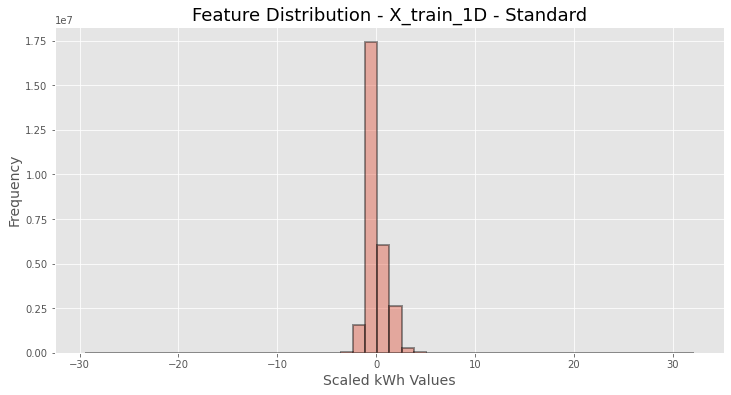

In [20]:
plot_feature_distribution(X_train_1D, arr_name='X_train_1D - Standard')

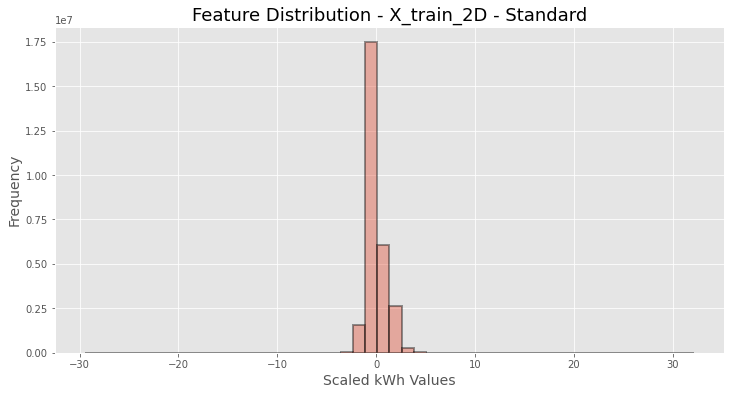

In [21]:
plot_feature_distribution(X_train_2D, arr_name='X_train_2D - Standard')

## Test 2 - Shapes

Once unravelled, the 2D data should have the shape as the 1D data (as long as we account for the zeroes that were appended during the transformation).

In [0]:
# Same number of samples in 1D and 2D data?
assert(X_train_1D.shape[0] == X_train_2D.shape[0])

In [0]:
# Are all original kWh values in the 1D and 2D data preserved? Test with first example
# Indexing until the second last value because 2 zeros added in 2D data - don't consider those
# All values expect for the appended zeros must match
assert np.all(X_train_1D[0] == X_train_2D[0].ravel()[:-2])

In [0]:
# Confirming that this ^ is the case for all 1D and 2D training examples
assert np.all([X_1D.ravel() == X_2D.ravel()[:-2] for (X_1D, X_2D) in zip(X_train_1D, X_train_2D)])

In [0]:
# Confirm that the only data added to 2D train is the data added during zero padding
PADDING = 2 

# Number of values added to the 1D data during padding = 2 zeros per consumer 
VALS_ADDED = PADDING * len(X_train)

# Difference betwween count of 2D and 1D data = number of zeroes added
assert X_train_2D.ravel().shape[0] - X_train_1D.ravel().shape[0] == VALS_ADDED

# Preparing WDNN

Previously, we've tuned hyperparameters of our `keras` models by wrapping them up in a `KerasClassifier` that is compatible with `keras`'s API for `scikit-learn`. This classifier is then passed as an estimator to a `GridSearchCV` from `sklearn` along with a `param_grid` that defines the hyperparameter space. 

However, we can't use this approach with the WDNN because the `keras` Scikit-Learn API only supports `Sequential` models, whereas the WDNN is built with a functional API. 

## Build Function

This function can be used to build a customised WDNN with user-defined hyperparameters. These include

**For WNN Densely Connected Layer**
- `wnn_units`: number of hidden units. This must be equal to the number of hidden units in the CNN's Dense layer if the two outputs are to be merged with `add, subtract, multiply, dot` or any other merging function that requires same dimensionality of inputs. 
- `wnn_activation`: the activation function.

**For CNN's Convolutional Layers**
- `cnn_filters`: Same for all layers, according to Zheng's architecture, but you can change these.
- `cnn_activation`: `relu` and `tanh` are worth investigating.
- `cnn_kernel_size`

**For CNN Pooling**
- `cnn_pool_size`
- TODO: add option to use other pooling layers. 

**For CNN Densely Connected Classifier**
- `cnn_dense_activation`: activation function for densely connected classiifer units.

**Compilation**
- `optimizer`

**Other Params**
- `show_summary`: if `True`, will print result of `model.summary()`.
- `show_graph`: if `True`, will display an image of the  computation graph of the model. 



In [0]:
def build_WDNN(wnn_activation='relu', wnn_units=60, cnn_activation='relu',
               cnn_filters=18, cnn_kernel_size=(3, 3), cnn_pool_size=(3, 3), 
               cnn_dense_activation='relu', optimizer='adam', show_summary=False,
               show_graph=False): 
  """Function that builds a WDNN with the specified hyperparameters. Will be passed
  as a build function to a `kerasClassifier` wrapper"""
  # Defining some constants - bad practice, need to find a way to do this automatically
  num_features = 1034 
  weeks_per_consumer = 148
  days_per_week = 7
  channels = 1

  # INPUT LAYERS
  wnn_input = keras.layers.Input(name='wnn_input', shape=(num_features,))
  cnn_input = keras.layers.Input(name='cnn_input',
                                 shape=(weeks_per_consumer, days_per_week, channels))
  
  # WNN HIDDEN LAYERS
  wnn_dense_1 = keras.layers.Dense(activation=wnn_activation, units=wnn_units)(wnn_input)


  # CNN HIDDEN LAYERS
  # First convolutional layer
  cnn_conv_1 = keras.layers.Conv2D(filters=cnn_filters, activation=cnn_activation, 
                                    padding='same', kernel_size=cnn_kernel_size)(cnn_input)

  # Second Conv2D
  cnn_conv_2 = keras.layers.Conv2D(filters=cnn_filters, activation=cnn_activation, 
                                    padding='same', kernel_size=cnn_kernel_size)(cnn_conv_1)

  # Third Conv2D
  cnn_conv_3 = keras.layers.Conv2D(filters=cnn_filters, activation=cnn_activation, 
                                    padding='same', kernel_size=cnn_kernel_size)(cnn_conv_2)

  # Fourth Conv2D
  cnn_conv_4 = keras.layers.Conv2D(filters=cnn_filters, activation=cnn_activation, 
                                    padding='same', kernel_size=cnn_kernel_size)(cnn_conv_3)

  # Fifth Conv2D
  cnn_conv_5 = keras.layers.Conv2D(filters=cnn_filters, activation=cnn_activation,
                                    padding='same', kernel_size=cnn_kernel_size)(cnn_conv_4)

  # CNN Max Pooling
  cnn_max_pooling_2d = keras.layers.MaxPooling2D(pool_size=cnn_pool_size)(cnn_conv_5)

  # Fully connected classifier
  cnn_flatten = keras.layers.Flatten()(cnn_max_pooling_2d)
  
  # Number of units must be same as wnn_dense_1 if usign `add`, `subtract`, `multiply`, `dot` for merge 
  cnn_dense_1 = keras.layers.Dense(units=wnn_units, 
                                   activation=cnn_dense_activation)(cnn_flatten)

  # Merge CNN and WNN outputs
  merged_outputs = keras.layers.add(inputs=[wnn_dense_1, cnn_dense_1])

  # Output
  wdnn_output = keras.layers.Dense(units=1, activation='sigmoid', name='main_output')(merged_outputs)

  # Build the computation graph and return it 
  wdnn_model = keras.models.Model(inputs={'wnn_input': wnn_input, 'cnn_input': cnn_input}, 
                            outputs={'wdnn_output': wdnn_output})
  
  # Compile it with the optimizer
  wdnn_model.compile(loss='binary_crossentropy', metrics=[keras.metrics.AUC()], 
                     optimizer=optimizer)
  
  # Optionally, print summary and show model graph
  if show_summary:
    print(wdnn_model.summary())
  
  # Optionally, show an image of the model's architecture
  if show_graph:
    keras.utils.plot_model(wdnn_model, show_shapes=True, show_layer_names=True, 
                           to_file='model.png')

  # Return wdnn_model
  return wdnn_model

### TODOS
- **Add option to dynamically vary the number of CNN layers**.
    - Must write a for loop.
    - Use variable to keep track of previous layer.
    - Route output of last layer to flatten.
    - Can each layer have its own filter count?
- **Add option to change merging function**
    - Will require some assertions and tests to confirm shape compatibility.
    - Options: `add`. `subtract`, `multiply`, `dot`, `average`, `concatenate`.
- **Add Regularization**
    - How to do this dynamically? 
    - Should dropout be added after every layer? Only the CNN layers? Shoud dropout rates be the same?
    - Why dropout? Why not L1/L2/L1-L2 regularization? How to specify the rate?
    - Batch normalization?
- **Fix `plot_model`**


## Does the build function work?

In [28]:
wdnn_model = build_WDNN(show_graph=True, show_summary=True)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
cnn_input (InputLayer)          [(None, 148, 7, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 148, 7, 18)   180         cnn_input[0][0]                  
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 148, 7, 18)   2934        conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 148, 7, 18)   2934        conv2d_1[0][0]                   
______________________________________________________________________________________________

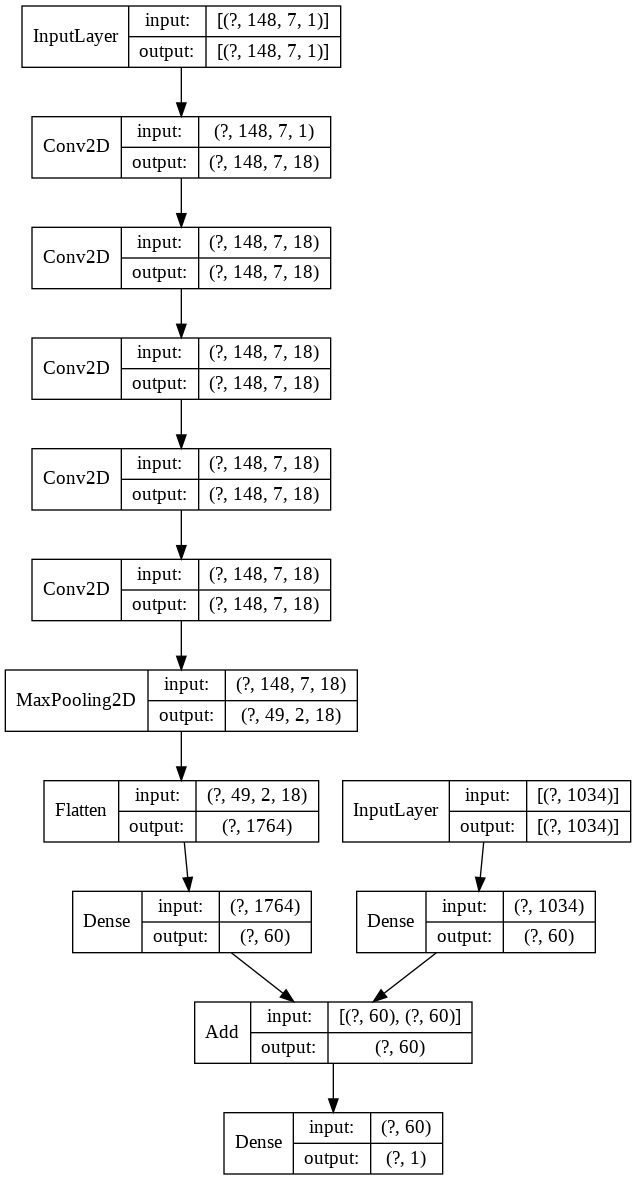

In [29]:
keras.utils.plot_model(wdnn_model, show_shapes=True, show_layer_names=False)

# WDNN Workflow

## Step 0 - Train/Test/Val Data Preparation

For all three sets, the flow is 
- `data_1D` = `original_data` -> `pipeline_1D` 
- `data_2D` = `data_1D` -> `pipeline_2D` 

Only the features are passed to the pipelines' `fit_transform`. 

In [0]:
# Training data 
X_train_1D = pipeline_1D.fit_transform(X_train)
X_train_2D = pipeline_2D.fit_transform(X_train_1D)
y_train_copy = y_train.copy()

# Validation data
X_val_1D = pipeline_1D.fit_transform(X_val)
X_val_2D = pipeline_2D.fit_transform(X_val_1D)
y_validation = y_val.copy()

Prepare test set at the very end.

## Step 1: Build a List of Models

Try and make models with all except one hyperparameter same. For this test hyperparameter, you can specify different values.

As an example, I am building 4 different WDNNs. Each as a different number of filters for the convolutional layers.

In [0]:
# This is your list of hyperparameters
cnn_filters_to_test = [6, 12, 18, 24]

# Use list comprehension to build a list of models with a call to the build_WDNN function
cnn_filter_models = [build_WDNN(cnn_filters=n_filters) for n_filters in cnn_filters_to_test]

This can also be done with combinations of features. In the cell below, I want to build models using 
- 3 different CNN activations
- 3 different WNN activations
- 2 different CNN filter values

which makes for a total of $3 \times 3 \times 2 = 18$ unique models. 

In [33]:
# Define individual hyperparameter values
cnn_filter_space = [8, 12]
cnn_activation_space = ['relu', 'tanh', 'selu']
# wnn_activation_space = ['relu', 'tanh', 'selu']

# Hyperparameter space is a list of combinations made through list comprehension
feature_space = [(filters, cnn_act) 
                 for filters in cnn_filter_space 
                 for cnn_act in cnn_activation_space]
                #  for wnn_act in wnn_activation_space]

# Did it work
print(feature_space)

# How to use this with build function? Use some tuple unpacking
filter_activation_models = [build_WDNN(cnn_filters=filters, cnn_activation=cnn_act) for
                            (filters, cnn_act) in feature_space]

# If this worked, we should have 6 different models in `filter_activation_models`
len(filter_activation_models)      

[(8, 'relu'), (8, 'tanh'), (8, 'selu'), (12, 'relu'), (12, 'tanh'), (12, 'selu')]


6

## Step 2 - Train Individual Models

Make sure they're trained on the same data. Save their training histories (by name in a dictionary, if possible).

Completely optional: use an `EarlyStopping` callback to stop training when the model's validation set data hasn't been 

### Callbacks

In [0]:
# Early stopping: stop training if val loss stagnates for more than 3 epochs 
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                            restore_best_weights=True, 
                                            patience=5)

### Training

In [0]:
# Create an empty list to which model histories will be appended
model_histories = {}

# Print which model is being trained
for (i, model) in enumerate(cnn_filter_models):
  # Fit the model - this is going to be a messy call
  history = model.fit(
      # Training Features: named dictionary, keys is layer name, value is tensor
      x={'wnn_input': X_train_1D, 'cnn_input': X_train_2D}, 

      # Training Labels: only one output, so don't need to specify name
      y=y_train_copy, 

      # Overfits very quickly, so training for few epochs
      epochs=1, 

      # Smaller batch sizez (8 - 16) -> less likely to go out of memory
      batch_size=16, 

      # Stop training if validation loss doesn't improve in 5 epochs
      callbacks=[es_callback], 

      # Print full logs for now
      verbose=1, 

      # Must specify validation data in same format as training data
      validation_data=({'wnn_input': X_val_1D,'cnn_input': X_val_2D}, y_validation)
  )

  # At the end of training, append the history to the list of model histories
  # Use hyperparam combo as key
  model_histories[str(feature_space[i])] = history